In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random as rnd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
from functools import reduce
from operator import add
from datetime import datetime
from pycm import ConfusionMatrix
import h5py
import librosa

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_transform as tft
import keras
from keras.models import Sequential
from keras.layers import (Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, 
                          AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, SeparableConv2D,
                          SeparableConv1D, AveragePooling1D, GlobalAveragePooling1D)
from tensorflow.keras import mixed_precision
import os
# import h5py
# import cv2

# import dill as pickle
import pickle5 as pickle
import collections

seizure_type_data = collections.namedtuple('seizure_type_data', ['patient_id','seizure_type', 'data'])

seed = 73


# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)

# 2. Set `python` built-in pseudo-random generator at a fixed value
rnd.seed(seed)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed)

%matplotlib inline
%load_ext tensorboard

In [7]:
path_drive = '/home/manu/Documents/1_UPM/TFM/code/'
path_dataset = '/home/manu/Documents/1_UPM/TFM/code/images/spectrogram_fft_seizures_wl1_ws_0.75_sf_250_fft_min_1_fft_max_24_diff_seizures/'
# path_dataset = '/home/manu/Documents/1_UPM/TFM/code/images/spectrogram_fft_seizures_wl2_ws_1_sf_250_fft_min_1_fft_max_24/'

In [8]:
f_cv = 'cv_split_3_fold_patient_wise_v1.5.2.pkl'

with open(path_drive+f_cv, 'rb') as f:
    cv = pickle.load(f)

In [9]:
for k, v in cv.items():
    for fold in v:
        paths = [s.split('.')[0] for s in cv[k][fold]]
        cv[k][fold] = paths

In [10]:
existing_files = set(os.listdir(path_dataset))

In [11]:
def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

def get_seizure_set(l):
    seizures_per_session = [listdir_fullpath(os.path.join(path_dataset, seizure_patient)) for seizure_patient in l]
    l_seizures = [item for sublist in seizures_per_session for item in sublist]
    return l_seizures

In [12]:
test = list(set(cv['1']['val']).intersection(existing_files))
train_val = list(set(cv['1']['train']).intersection(existing_files))
train_val_labels = [path.split('_')[-1][:4] for path in train_val]

train, val = train_test_split(train_val, test_size=.05, random_state=seed, 
                              shuffle=True, stratify=train_val_labels)

train, val, test = list(map(get_seizure_set, [train, val, test]))

In [13]:
with open(path_drive+'dict_seizures.pickle', 'rb') as f:
    d_seizures = pickle.load(f)

def get_generator(f, l_paths):
    def func():
        return f(l_paths)
    return func

def read_train_data(train):
    df_train = pd.DataFrame(train, columns=['fullpath'])
    df_train['dir'] = df_train['fullpath'].str.split('/').map(lambda l: l[-2])
    train_dirs = list({path.split('/')[-2] for path in train})
    rnd.shuffle(train_dirs)
    
    for d in train_dirs:
        path = df_train[df_train['dir']==d]['fullpath'].sample(1).values[0]
        with h5py.File(path, mode='r') as f:
            data = np.array(f['data']).astype(np.float32)
        y = d_seizures[path.split('type_')[1][:4]]
        arr = np.zeros(len(d_seizures.keys())).astype(np.float32)
        arr[y] = 1.
        data = librosa.amplitude_to_db(data, ref=np.max, top_db=200.0)
        yield data, arr

def read_test_data(l_paths):
    test_dirs = pd.Series(list({path.split('/')[-2] for path in l_paths})).sort_values().values
    for d in test_dirs:
        for path in [t for t in l_paths if d in t]:
            with h5py.File(path, mode='r') as f:
                data = np.array(f['data']).astype(np.float32)
            y = d_seizures[path.split('type_')[1][:4]]
            arr = np.zeros(len(d_seizures.keys())).astype(np.float32)
            arr[y] = 1.
            data = [librosa.amplitude_to_db(d, ref=np.max, top_db=200.0) for d in data]
            yield data, arr

In [14]:
it = iter(read_train_data(train))

In [15]:
e = next(it)
(e[0].shape, e[1].shape)

((13, 14, 20), (7,))

In [16]:
def get_tf_dataset(l_paths, batch_size, f, augmentation=False):
    ds = tf.data.Dataset\
    .from_generator(get_generator(f, l_paths), output_types=(tf.float32, tf.float32), 
                    output_shapes=(e[0].shape, e[1].shape))
    
    if augmentation:
        ds= ds\
            .map(lambda x, y: (tf.image.random_flip_left_right(x, seed=seed), y))\
            .map(lambda x1, y1: (tf.image.random_brightness(x1, .4, seed=seed), y1))\
            .map(lambda x2, y2: (tf.image.random_contrast(x2, .2, .5, seed=seed), y2))
    
    ds = ds.\
        batch(batch_size)

    
    return ds

In [17]:
ds_train = get_tf_dataset(train, 1, read_train_data)
ds_val = get_tf_dataset(val, 1, read_test_data)
ds_test = get_tf_dataset(test, 1, read_test_data)

In [18]:
it = iter(ds_test)

## Input Sample

[[1. 0. 0. 0. 0. 0. 0.]]


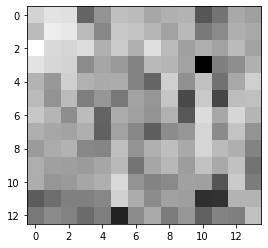

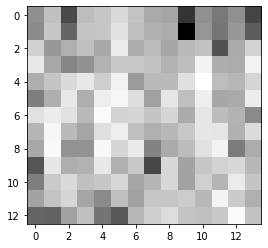

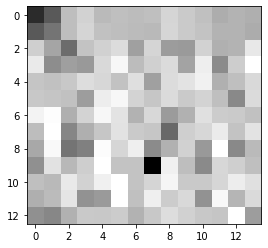

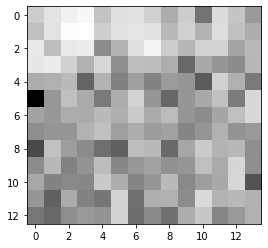

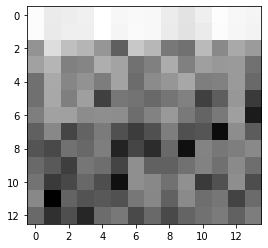

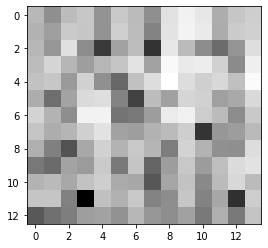

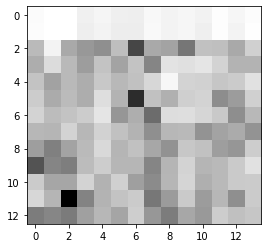

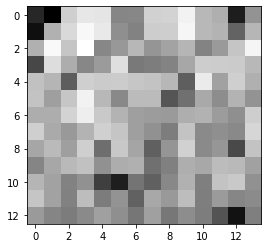

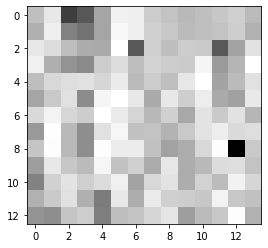

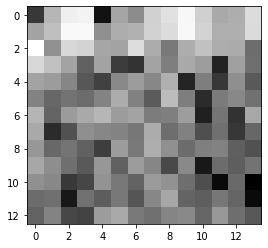

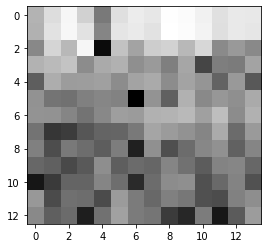

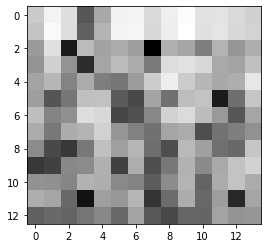

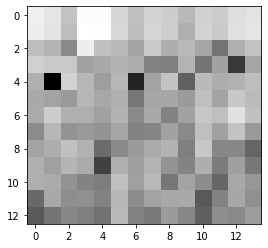

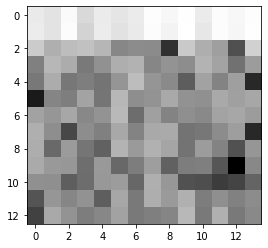

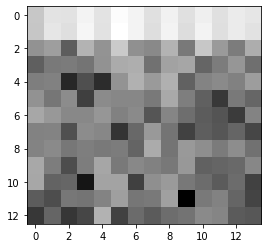

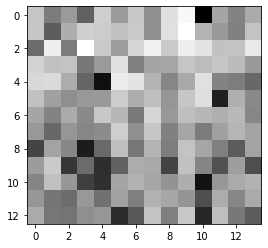

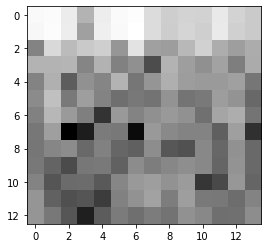

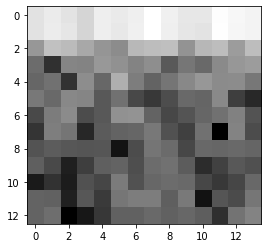

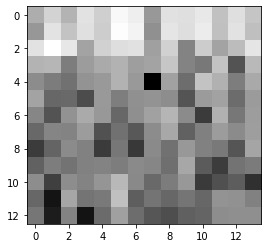

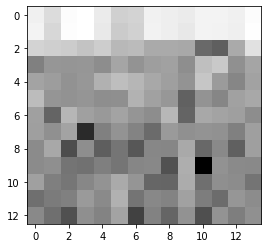

In [19]:
import matplotlib.pyplot as plt
tup = next(it)
print(tup[1].numpy())
for i in range(tup[0][0].shape[2]):
    img = tup[0][0][:,:,i].numpy()
    plt.figure()
    plt.imshow(img, cmap='gray')
    img.min(), img.max()

## CNN

In [27]:
w_f1 = tfa.metrics.F1Score(len(d_seizures.keys()), average='weighted', name='w_f1')

In [28]:
tup[0].numpy().shape[1:]

(13, 14, 20)

In [31]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [ ]:
exp_name = 'results.pkl'
exp_path = 'exp_results/'+nb_name.split('.')[0]+datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
os.makedirs(exp_path, exist_ok=True)
exp_path_results = os.path.join(exp_path, exp_name)
print(exp_path_results)

for i_split in range(1, 4):
    i_split = str(i_split)
    print(f'Processing split {i_split}')
    batch_size = 128
    num_classes = len(d_seizures.keys())
    epochs = 200

    # Get the actual batch
    train_val = list(set(cv['1']['train']).intersection(existing_files))

    train_val_labels = [path.split('_')[-1][:4] for path in train_val]
    train, val = train_test_split(train_val, test_size=.1, random_state=seed, 
                                  shuffle=True, stratify=train_val_labels)

    train, val = list(map(get_seizure_set, [train, val]))

    ds_train = get_tf_dataset(train, batch_size, read_train_data)
    ds_val = get_tf_dataset(val, batch_size, read_test_data)

    model = tf.keras.Sequential()
    model.add(SeparableConv2D(64, (3, 3), 
                              depthwise_regularizer=tf.keras.regularizers.l1_l2(),
                              pointwise_regularizer=tf.keras.regularizers.l1_l2(),
                              input_shape=tup[0].numpy().shape[1:]))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(SeparableConv2D(64, (3, 3),
                              depthwise_regularizer=tf.keras.regularizers.l1_l2(),
                              pointwise_regularizer=tf.keras.regularizers.l1_l2(),))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    if i_split=='1':
        model.summary()
#         break

    opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

    # TensorBoard
    logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
    # tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    early_stopping = tf.keras\
        .callbacks.EarlyStopping(monitor='val_w_f1', patience=30,
                                 restore_best_weights=False,
                                 verbose=1, mode='max',
                                 min_delta=0.01)
    
    model_path = os.path.join(exp_path, f'model_cv_{i_split}')
    model_checkpoint_callback = tf\
        .keras.callbacks\
        .ModelCheckpoint(filepath=model_path,
                        save_weights_only=False,
                        monitor='val_w_f1',
                        mode='max', verbose=1,
                        save_best_only=True)

    model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy', w_f1])

    model.fit(ds_train.repeat(),
            epochs=epochs,
            steps_per_epoch=50,
            validation_data=ds_val,
            shuffle=False,
#             class_weight=cw,
            callbacks=[early_stopping, model_checkpoint_callback])

## Results

In [28]:
exp_path = 'exp_results/tuh_spectrogram_experiment_12021_04_06_08_13_33'
d_key_seizures = {v: k for k, v in d_seizures.items()}
n_classes = len(d_seizures.keys())

In [27]:
def get_prob_record_patient(series):
    arr = np.zeros(n_classes)
    series = series/series.sum()
    ind = series.index
    values = series.values
    arr[ind] = values
    return list(arr)

In [22]:
from itertools import cycle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

1373/1373 [==============================] - 210s 153ms/step
CV 1. f1_frame: 0.4851, f1_seizure_patient: 0.5469


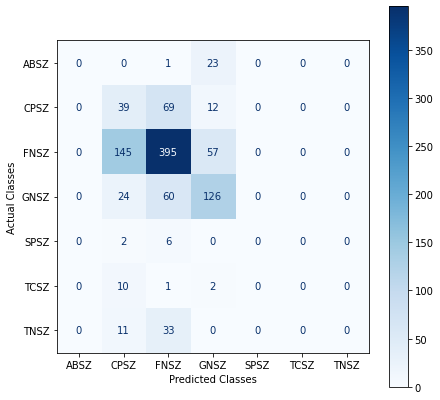

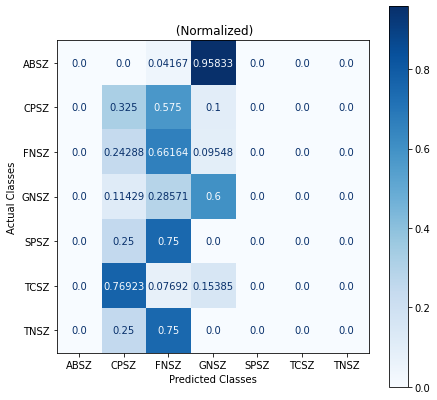

Average precision score, micro-averaged over all classes: 0.46


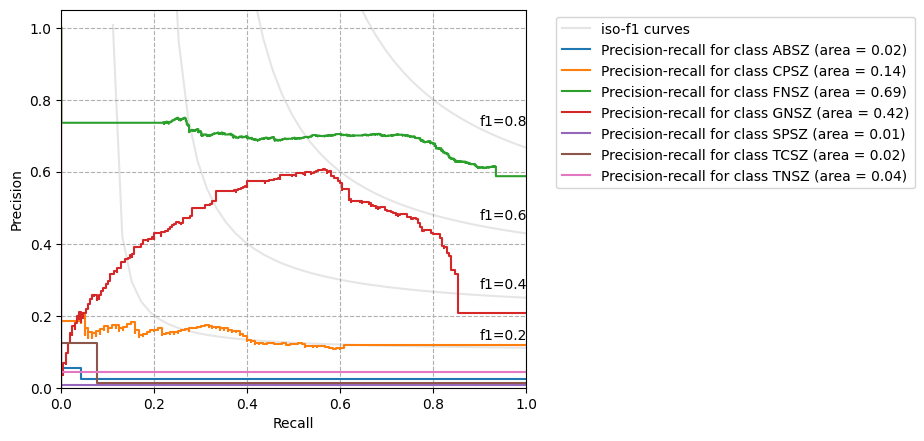

1732/1732 [==============================] - 251s 145ms/step
CV 2. f1_frame: 0.5414, f1_seizure_patient: 0.6708


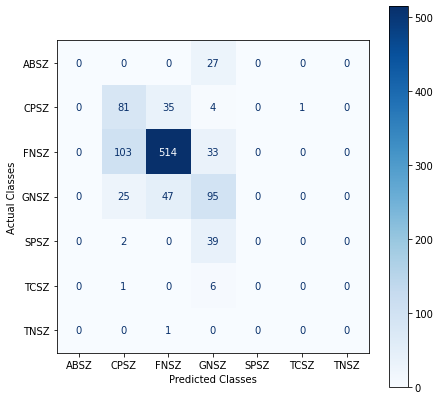

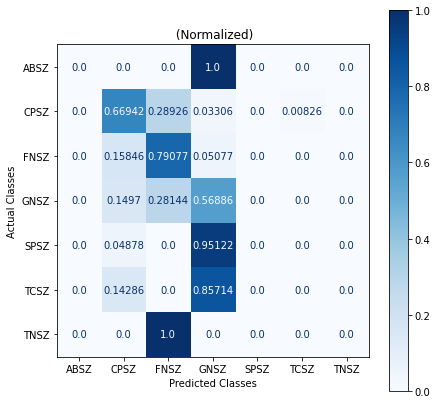

Average precision score, micro-averaged over all classes: 0.70


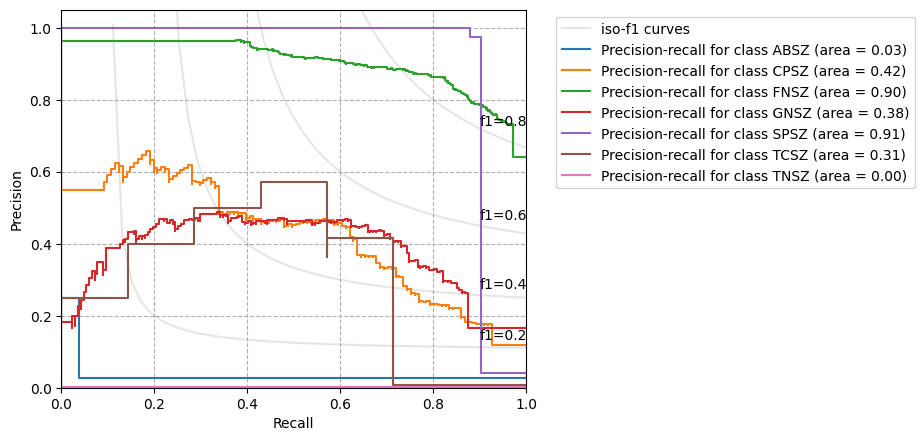

1597/1597 [==============================] - 227s 142ms/step
CV 3. f1_frame: 0.5354, f1_seizure_patient: 0.5806


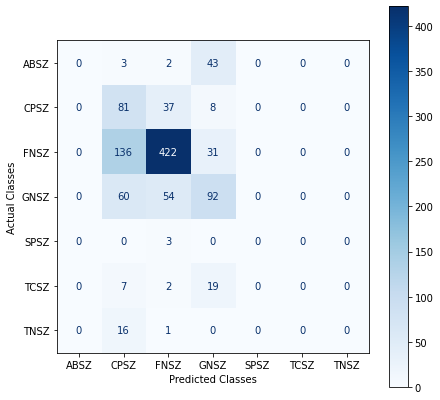

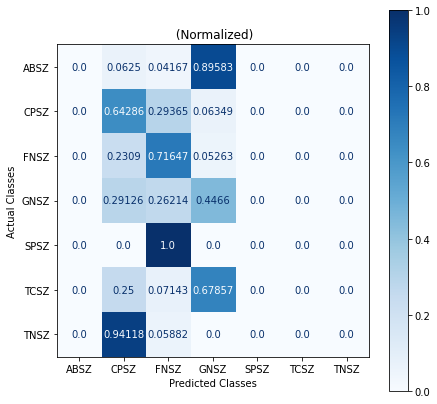

Average precision score, micro-averaged over all classes: 0.57


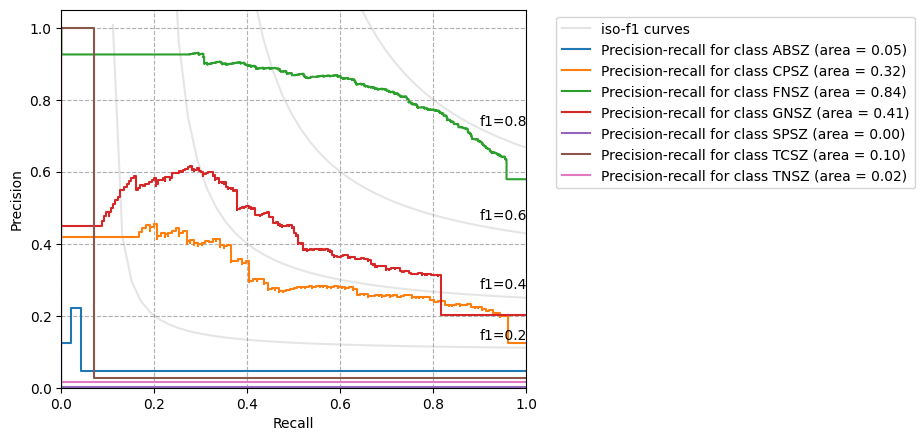

0.520671481565821 0.025242384185676925
0.5994232372382978 0.05234262457900047
FNSZ    0.812940
GNSZ    0.404398
CPSZ    0.291587
ABSZ    0.037439
SPSZ    0.305522
TCSZ    0.141945
TNSZ    0.020336
dtype: float64
FNSZ    0.108286
GNSZ    0.023114
CPSZ    0.143823
ABSZ    0.013931
SPSZ    0.519812
TCSZ    0.148198
TNSZ    0.021391
dtype: float64


In [75]:
l_f1_seizure_patient = []
l_f1_frame = []
l_prc = []

for i in range(1, 4):
    arr_metrics = np.zeros(n_classes)
    # Read model
    i_split = str(i)
    path_model = os.path.join(exp_path, f'model_cv_{i_split}')

    model = keras.models.load_model(path_model)
    
    test = list(set(cv[i_split]['val']).intersection(existing_files))
    test = get_seizure_set(test)

    
    
    y_pred = np.argmax(model.predict(
        get_tf_dataset(test, 64, read_test_data), verbose=1), axis=-1)
    ds_test = get_tf_dataset(test, 1, read_test_data)
    y_true = [np.where(e[1].numpy()[0] == 1)[0][0] for e in iter(ds_test)]

    # F1 per image
    f1_frame = f1_score(y_true, y_pred, average='weighted')

    # F1 per EEG
    y_size = pd.Series([path.split('/')[-2] for path in test]).value_counts().sort_index().values
    y_ = np.cumsum(y_size)
    slice_index = zip(np.insert(y_, 0, 0)[:-1], y_)
    l_results = [(y_true[l],
                  pd.Series(y_pred[l:r]).value_counts().index[0],
                  pd.Series(y_pred[l:r]).value_counts())
                 for l, r in slice_index]
    df_results = pd.DataFrame(l_results)
    f1_seizure_patient = f1_score(
        df_results[0], df_results[1], average='weighted')
    
    
    
    l_f1_frame.append(f1_frame)
    l_f1_seizure_patient.append(f1_seizure_patient)
    
    print(f'CV {i_split}. f1_frame: {round(f1_frame, 4)}, f1_seizure_patient: {round(f1_seizure_patient, 4)}')

    cm = ConfusionMatrix(actual_vector=df_results[0].values, 
                         predict_vector=df_results[1].values) # Create CM From Data
    cm.relabel(mapping=d_key_seizures)
    cm.plot(cmap=plt.cm.Blues,number_label=True,plot_lib="matplotlib", title='')

    fig = plt.gcf()
    fig.set_size_inches(7, 7)
    # fig.savefig('test2png.png', dpi=100)

    cm.plot(cmap=plt.cm.Blues,number_label=True, normalized=True, plot_lib="matplotlib", title='')
    fig = plt.gcf()
    fig.set_size_inches(7, 7)
    plt.show()
    
    
    # From the count per class to normalize between 0-1 to get probability
    df_results['prob'] = df_results[2].map(get_prob_record_patient)
    Y_test = label_binarize(df_results[0].values, classes=range(n_classes))
    y_score = np.array(df_results['prob'].tolist())

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                            y_score[:, i])
        average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
        y_score.ravel())
    average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                         average="micro")
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'
          .format(average_precision["micro"]))

    fig, ax = plt.subplots(figsize=(6,6), dpi=100)

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))
    
    lines.append(l)
    labels.append('iso-f1 curves')

    for i in [c for _, c in sorted(d_seizures.items())]:
        l, = plt.step(recall[i], precision[i], lw=1.5, where='post')
        lines.append(l)
        labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                      ''.format(d_key_seizures[i], average_precision[i]))
        arr_metrics[i] = average_precision[i]

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # plt.title('Extension of Precision-Recall curve to multi-class')
    ax.grid(linestyle='--')
    plt.legend(lines, labels, bbox_to_anchor=(1.05, 1))
    plt.show()
    l_prc.append(arr_metrics)
    

print(np.mean(l_f1_frame), np.std(l_f1_frame))
print(np.mean(l_f1_seizure_patient), np.std(l_f1_seizure_patient))
df = pd.DataFrame(l_prc)
df.columns = df.columns.map(d_key_seizures)
print(df.mean())
print(df.std())

In [76]:
pd.DataFrame([df.mean(), df.std()]).T.sort_index().round(2)

,0,1
ABSZ,0.04,0.01
CPSZ,0.29,0.14
FNSZ,0.81,0.11
GNSZ,0.40,0.02
SPSZ,0.31,0.52
TCSZ,0.14,0.15
TNSZ,0.02,0.02
